In [1]:
%load_ext autoreload

In [214]:
%autoreload
import copy
import sys
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from einops import rearrange
from functorch import vmap
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm

sys.path.append("/scratch/gpfs/js5013/programs/cfilt/")
from cfilt.utils import *

In [84]:
def remove_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v

    return new_state_dict

In [99]:
class Cascade(nn.Module):
    def __init__(self, base_model, load_paths):
        super().__init__()
        self.models = [copy.deepcopy(base_model) for _ in range(len(load_paths))]
        for i, m in tqdm(enumerate(self.models), total=len(load_paths)):
            state_dict = torch.load(load_paths[i])
            state_dict = remove_data_parallel(state_dict)
            m.load_state_dict(state_dict)
        self.models = nn.ModuleList(self.models)
        self.intermediates = []

    def get_intermediates(self):
        return self.intermediates

    def forward(self, x):
        self.intermediates.clear()
        for m in self.models:
            x = m(x)
            self.intermediates.append(x)
        return x

In [125]:
ds = CDS(
    [1, 4, 8, 16, 32, 80, 160, 320, 1600],
    "jx",
    "../out/",
    normalize=True,
    transform=transforms.ToTensor(),
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [202]:
train_len = int(len(ds) * 0.95)
train_ds, test_ds = random_split(ds, (train_len, len(ds) - train_len))

dl_cfg = dict(
    batch_size=4,
    shuffle=True,
    collate_fn=unpack,
    num_workers=16,
    pin_memory=True,
)
train_dl = DataLoader(train_ds, **dl_cfg)
test_dl = DataLoader(test_ds, **dl_cfg)

In [174]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [175]:
ac = nn.Sequential(
    ConvXCoder((125, 133), 1, 4, 4, 3, device),
    ConvXCoder((125, 133), 4, 1, 4, 3, device),
)

In [176]:
csc = Cascade(
    ac,
    [
        f"../models/convxcoder/{low}-{high}-3l-4c-new.pt"
        for low, high in zip(
            [1, 4, 8, 16, 32, 80, 160, 320], [4, 8, 16, 32, 80, 160, 320, 1600]
        )
    ],
).to(device)

  0%|          | 0/8 [00:00<?, ?it/s]

In [179]:
optimizer = torch.optim.Adam(csc.parameters(), lr=1e-3)
loss_fn = MS_SSIM_L1_Loss(alpha=0.7)
maploss = vmap(loss_fn, in_dims=0)

In [224]:
denormalize = lambda x, mean, std: x * std + mean
mapdenorm = vmap(denormalize, in_dims=0)

In [229]:
im = csc.get_intermediates()
torch.stack(im).shape

torch.Size([8, 4, 1, 125, 133])

In [262]:
epochs = 50
means = torch.tensor(list(ds.mean.values()))[1:].reshape(-1, 1, 1, 1, 1).to(device)
stds = torch.tensor(list(ds.std.values()))[1:].reshape(-1, 1, 1, 1, 1).to(device)
weights = torch.arange(8, 0, step=-1).to(device)
losses = []
for e in (pbar := tqdm(range(epochs))):
    csc.train()
    for i, x in enumerate(train_dl):
        optimizer.zero_grad()

        out = csc(x[0].to(device))
        im = csc.get_intermediates()

        im = torch.stack(im)  # * stds + means
        truths = torch.stack(x[1:]).to(device)  # * stds + means

        loss = (maploss(im, truths) * weights).sum()

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    pbar.set_description(f"loss: {loss.item():.2e}")

  0%|          | 0/50 [00:00<?, ?it/s]

/scratch/gpfs/js5013/.conda/envs/main/lib/python3.10/site-packages/torch/nn/functional.py:3249: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::l1_loss. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /__w/functorch/functorch/functorch/csrc/BatchedFallback.cpp:85.)
  return torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))


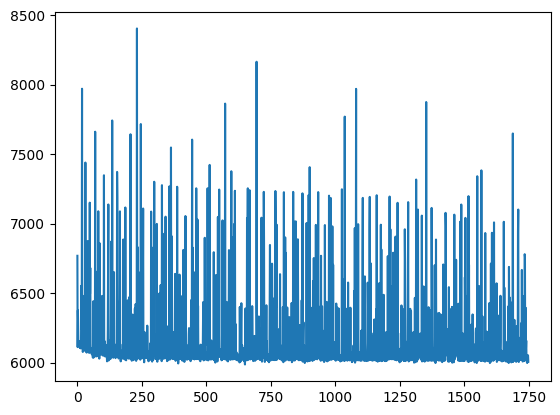

In [263]:
plt.plot(losses)

In [328]:
csc.eval()
x = next(iter(test_dl))
out = csc(x[0].to(device))
im = csc.get_intermediates()
im = torch.stack(im)  # * stds + means
truths = torch.stack(x[1:])  # .to(device) * stds + means

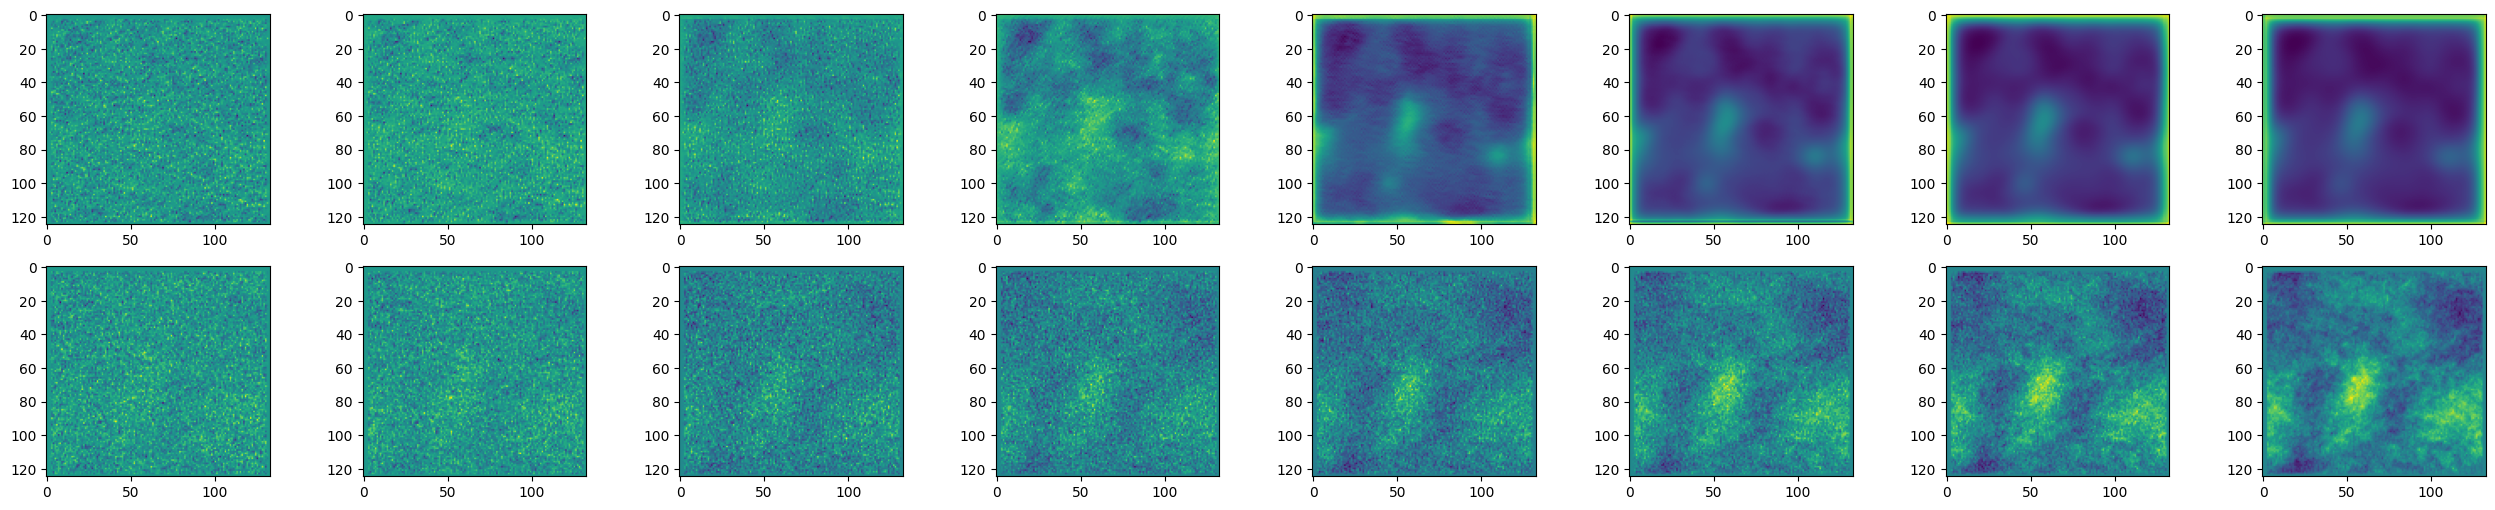

In [329]:
n = len(im)
fig, ax = plt.subplots(2, n, figsize=(4 * n, 6))
for i in range(8):
    ax[0, i].imshow(im[i][0][0].detach().cpu().numpy())
    ax[1, i].imshow(truths[i][0][0].detach().cpu().numpy())

In [293]:
def anisodiff(
    img, niter=1, kappa=50, gamma=0.1, step=(1.0, 1.0), option=1, ploton=False
):
    """
                                                                                Anisotropic diffusion.

                                                                                Usage:
                                                                                imgout = anisodiff(im, niter, kappa, gamma, option)

                                                                                Arguments:
                                                                                        img    - input image
                                                                                        niter  - number of iterations
        kappa  - conduction coefficient 20-100 ?
                                                                                        gamma  - max value of .25 for stability
                                                                                        step   - tuple, the distance between adjacent pixels in (y,x)
                                                                                        option - 1 Perona Malik diffusion equation No 1
                                                                                                 2 Perona Malik diffusion equation No 2
                                                                                        ploton - if True, the image will be plotted on every iteration

                                                                                Returns:
                                                                                        imgout   - diffused image.

                                                                                kappa controls conduction as a function of gradient.  If kappa is low
                                                                                small intensity gradients are able to block conduction and hence diffusion
                                                                                across step edges.  A large value reduces the influence of intensity
                                                                                gradients on conduction.

                                                                                gamma controls speed of diffusion (you usually want it at a maximum of
                                                                                0.25)

                                                                                step is used to scale the gradients in case the spacing between adjacent
                                                                                pixels differs in the x and y axes

                                                                                Diffusion equation 1 favours high contrast edges over low contrast ones.
                                                                                Diffusion equation 2 favours wide regions over smaller ones.

                                                                                Reference:
                                                                                P. Perona and J. Malik.
                                                                                Scale-space and edge detection using ansotropic diffusion.
                                                                                IEEE Transactions on Pattern Analysis and Machine Intelligence,
                                                                                12(7):629-639, July 1990.

                                                                                Original MATLAB code by Peter Kovesi
                                                                                School of Computer Science & Software Engineering
                                                                                The University of Western Australia
                                                                                pk @ csse uwa edu au
                                                                                <http://www.csse.uwa.edu.au>

                                                                                Translated to Python and optimised by Alistair Muldal
                                                                                Department of Pharmacology
                                                                                University of Oxford
                                                                                <alistair.muldal@pharm.ox.ac.uk>

                                                                                June 2000  original version.
                                                                                March 2002 corrected diffusion eqn No 2.
                                                                                July 2012 translated to Python
    """

    # ...you could always diffuse each color channel independently if you
    # really want
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)

    # initialize output array
    img = img.astype("float32")
    imgout = img.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    # create the plot figure, if requested
    if ploton:
        from time import sleep

        import pylab as pl

        fig = pl.figure(figsize=(20, 5.5), num="Anisotropic diffusion")
        ax1, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)

        ax1.imshow(img, interpolation="nearest")
        ih = ax2.imshow(imgout, interpolation="nearest", animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in range(niter):

        # calculate the diffs
        deltaS[:-1, :] = np.diff(imgout, axis=0)
        deltaE[:, :-1] = np.diff(imgout, axis=1)

        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gS = np.exp(-((deltaS / kappa) ** 2.0)) / step[0]
            gE = np.exp(-((deltaE / kappa) ** 2.0)) / step[1]
        elif option == 2:
            gS = 1.0 / (1.0 + (deltaS / kappa) ** 2.0) / step[0]
            gE = 1.0 / (1.0 + (deltaE / kappa) ** 2.0) / step[1]

        # update matrices
        E = gE * deltaE
        S = gS * deltaS

        # subtract a copy that has been shifted 'North/West' by one
        # pixel. don't as questions. just do it. trust me.
        NS[:] = S
        EW[:] = E
        NS[1:, :] -= S[:-1, :]
        EW[:, 1:] -= E[:, :-1]

        # update the image
        imgout += gamma * (NS + EW)

        if ploton:
            iterstring = "Iteration %i" % (ii + 1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return imgout

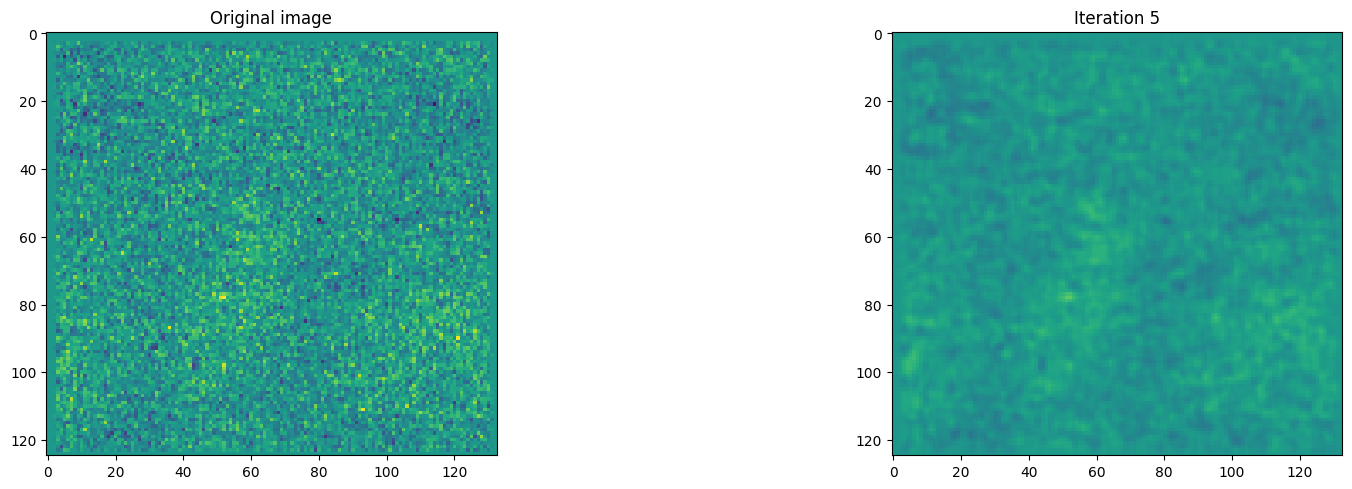

In [330]:
out = anisodiff(x[2][0][0].detach().cpu().numpy(), niter=5, option=1, ploton=True);

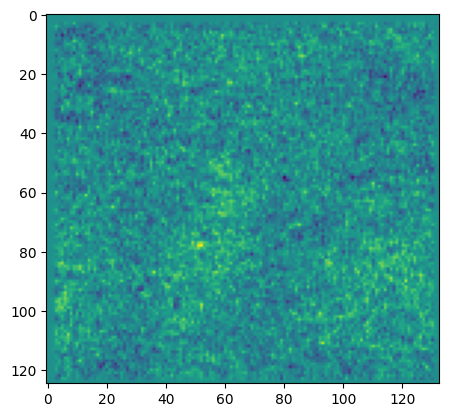

In [331]:
plt.imshow(x[2][0][0].detach().cpu().numpy() + out)

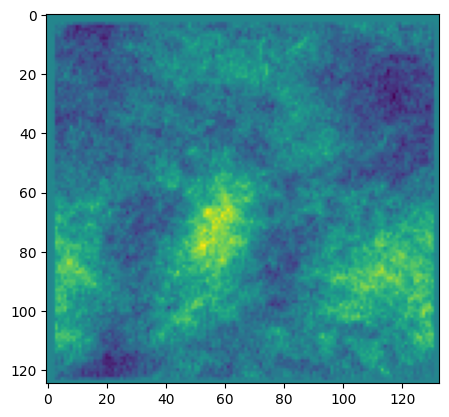

In [334]:
plt.imshow(truths[-1][0][0].detach().cpu().numpy())